In [1]:
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
from keras.models import Model
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model



total cores: 256


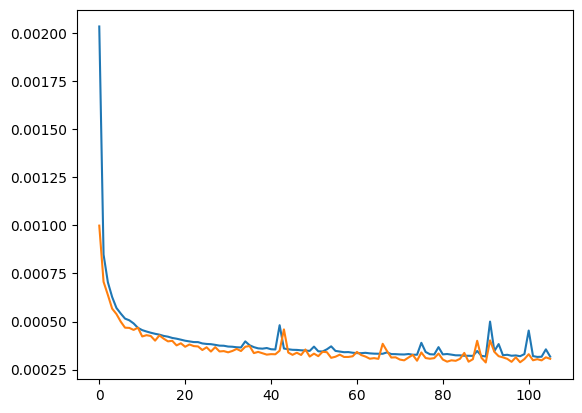

In [2]:
import pickle
with open('training_history_landmask_150k_1e3.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

plt.plot(loaded_history["loss"][:])
plt.plot(loaded_history["val_loss"][:])


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]
bands=[29]
#bands=[1]
folder = "/scratch/fslippe/modis/MOD02/daytime_1km/ /scratch/fslippe/modis/MOD02/boundary_1km/ /scratch/fslippe/modis/MOD02/night_1km/"


1 Physical GPUs, 1 Logical GPUs


2023-10-10 16:27:58.785494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21336 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [ ]:
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
#folder = "/scratch/fslippe/modis/MOD02/daytime_1km/"# /scratch/fslippe/modis/MOD02/boundary_1km/"# /scratch/fslippe/modis/MOD02/night_1km/"

start = "20201201"
end = "20210430"
# start = "20210401"
# end = "20210430"


start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
print(start_converted)
print(end_converted)
x, dates, masks = extract_1km_data(folder, bands=bands, start_date=start_converted, end_date=end_converted)
x, dates, masks = zip(*[(xi, date, mask) for xi, date, mask in zip(x, dates, masks) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])
x = list(x)
dates = list(dates)

#x = extract_250m_data(folder, bands=[1], start_date=start_converted, end_date=end_converted)
len(masks)




In [4]:
import autoencoder
import importlib
importlib.reload(autoencoder)
from autoencoder import SobelFilterLayer, SimpleAutoencoder
patch_size = 64
#normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data], axis=0)

In [5]:
from autoencoder import SobelFilterLayer, SimpleAutoencoder
patch_size = 64
print(len(bands))
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

#encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_band(6,20,29)_encoder")
encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_band(29)_filter_encoder")

1


In [7]:
max_vals = np.load("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_band(29)_max_vals.npy")
#max_vals = np.array([15.703261])
max_vals

array([[[[10.833669]]]], dtype=float32)

In [ ]:
#### EXTRACTING AND ENCODING PATCHES + SAVING indexes of belonging files
cluster_map = []
all_patches = []
starts = []
ends =[]
shapes = []
start = 0 

for (image, mask) in zip(x[:100], masks[:100]):
    shapes.append(image.shape[0:2])
    patches, idx, n_patches = autoencoder_predict.extract_patches(image, mask, mask_threshold=0.9)  # Assuming this function extracts and reshapes patches for a single image
    all_patches.append(patches)
    starts.append(start)
    ends.append(start + n_patches)
    start += len(patches)

# Stack filtered patches from all images
patches = np.concatenate(all_patches, axis=0) / max_vals


In [49]:
val_data = np.load("/scratch/fslippe/modis/MOD02/test_data/normalized_testpatches_dnb_landmask_150k_band(29)_winter20_21.npy")


In [50]:
encoded_patches = encoder.predict(val_data)
encoded_patches_flat = encoded_patches.reshape(encoded_patches.shape[0], -1)


In [8]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
start = "20230303"
end = "20230306"

#start = "20210701"
#end = "20210702"
start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
#x_cao, dates_cao, masks_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/july_2021/", bands=bands, start_date=start_converted, end_date=end_converted)

x_cao, dates_cao, masks_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/cao_test_data/", bands=bands, start_date=start_converted, end_date=end_converted)
x_cao, dates_cao, masks_cao = zip(*[(xi, date, mask) for xi, date, mask in zip(x_cao, dates_cao, masks_cao) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])
# x_cao, dates_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/cao_test_data/", bands=bands, start_date=start_converted, end_date=end_converted)
# x_cao, dates_cao = zip(*[(xi, date) for xi, date in zip(x_cao, dates_cao) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])
x_cao = list(x_cao)
dates_cao = list(dates_cao)

# start = "20210701"
# end = "20210702"

# start = "20210401"
# end = "20210402"
# start_converted = convert_to_day_of_year(start)
# end_converted = convert_to_day_of_year(end)
# start_converted = convert_to_day_of_year(start)
# end_converted = convert_to_day_of_year(end)
# x_no, dates_no, masks_no = extract_1km_data(folder, bands=bands, start_date=start_converted, end_date=end_converted)
# x_no, dates_no, masks_no = zip(*[(xi, date, mask) for xi, date, mask in zip(x_no, dates_no, masks_no) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])
# x_no = list(x_no)
# dates_no = list(dates_no)
# #x2 = [xi for xi in  extract_1km_data(folder, bands=[1], start_date=start_converted, end_date=end_converted) if xi.shape[0] > 64]


total cores: 256
['/scratch/fslippe/modis/MOD02/cao_test_data/']


100%|██████████| 4/4 [00:20<00:00,  5.22s/it]


In [9]:
#### EXTRACTING AND ENCODING PATCHES + SAVING indexes of belonging files
cluster_map_cao = []
all_patches_cao = []
starts_cao = []
ends_cao =[]
shapes_cao = []
start_cao = 0 
n_patches_tot = []
indices = []

for (image, mask) in zip(x_cao, masks_cao):
    shapes_cao.append(image.shape[0:2])
    patches_cao, idx_cao, n_patches = autoencoder_predict.extract_patches(image, mask, mask_threshold=0.9)  # Assuming this function extracts and reshapes patches for a single image
    #patches_cao = autoencoder_predict.extract_patches(image)  # Assuming this function extracts and reshapes patches for a single image
    
    n_patches_cao = len(patches_cao)
    all_patches_cao.append(patches_cao)
    starts_cao.append(start_cao)
    ends_cao.append(start_cao + n_patches_cao)
    n_patches_tot.append(n_patches)
    indices.append(idx_cao)
    start_cao += n_patches_cao

# Stack filtered patches from all images
patches_cao = np.concatenate(all_patches_cao, axis=0) / max_vals

encoded_patches_cao = encoder.predict(patches_cao)
encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)


# cluster_map_no = []
# all_patches_no = []
# starts_no = []
# ends_no =[]
# shapes_no = []
# start_no = 0 

# for image in x_no:
#     shapes_no.append(image.shape[0:2])
#     patches_no = autoencoder_predict.extract_patches(image)  # Assuming this function extracts and reshapes patches for a single image
#     all_patches_no.append(patches_no)
#     starts_no.append(start_no)
#     ends_no.append(start_no + len(patches_no))
#     start_no += len(patches_no)
#     # Calculate the dimensions of the reduced resolution array
# # Stack filtered patches from all images
# patches_no = np.concatenate(all_patches_no, axis=0) / max_vals
# encoded_patches_no = encoder.predict(patches_no)
# encoded_patches_flat_no = encoded_patches_no.reshape(encoded_patches_no.shape[0], -1)



2023-10-10 16:29:02.520368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


In [10]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib

#cluster = MiniBatchKMeans(11, batch_size=32, random_state=42).fit(encoded_patches_flat)
#joblib.dump(cluster, '/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_band(29).pkl')
cluster = joblib.load('/uio/hume/student-u37/fslippe/data/models/cluster_winter_2020_21_dnb_landmask_band(29)_lab1.pkl')

#decoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_band(29)_filter_encoder")


In [11]:
gc.collect()

2237

12
(21,)


ValueError: For X (139) and Y (1848) with flat shading, A should have shape (1847, 138, 3) or (1847, 138, 4) or (1847, 138) or (254886,), not (1847, 138, 1)

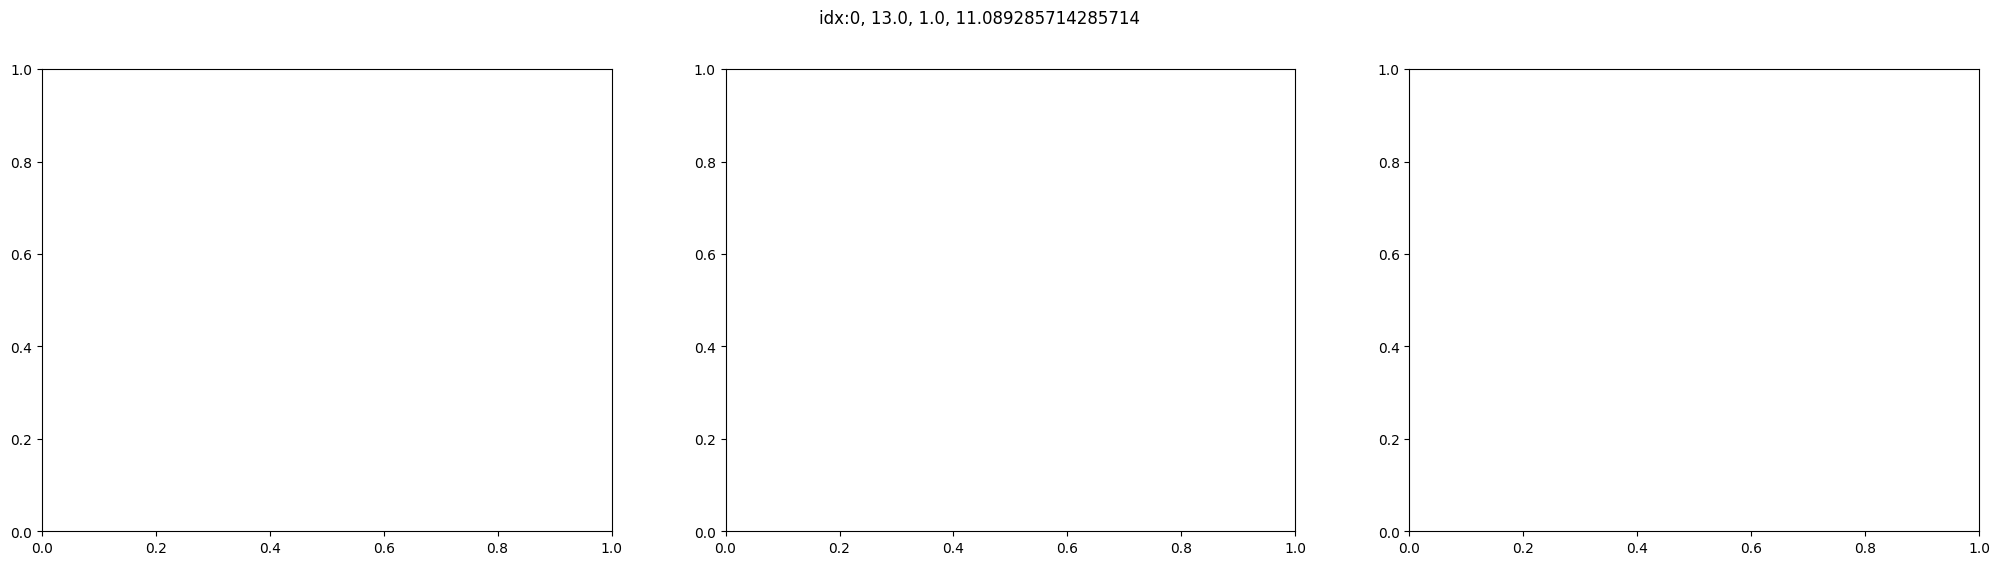

In [13]:
import matplotlib.colors as mcolors
index_list = [0,1,2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19]
#index_list = range(len(x_cao))
#index_list = [2]

#cluster_predict = cluster.predict(encoded_patches_flat_cao)
labels = cluster_predict#.labels_
cluster_map_cao = []

global_min = np.min([np.min(cm) for cm in cluster.labels_])
global_max = np.max([np.max(cm) for cm in cluster.labels_])+2
norm = Normalize(vmin=global_min, vmax=global_max)  
print(global_max)

norm_mask = Normalize(vmin=0, vmax=1)  

cmap_tab10 = plt.cm.tab10
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))

# Add black to the end
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, black))

# Create a new colormap from the combined list of colors
new_cmap = mcolors.ListedColormap(colors_new)
# boundaries = np.arange(global_max+1) 
# norm = mcolors.BoundaryNorm(boundaries, new_cmap.N, clip=True)
# Assuming your original data shape is (height, width)
for i in index_list:
    height, width = shapes_cao[i]

    # Calculate the dimensions of the reduced resolution array
    reduced_height = height // patch_size
    reduced_width = width //patch_size
    current_labels = np.ones((n_patches_tot[i]))*(global_max+1)
    print(labels[starts_cao[i]:ends_cao[i]].shape)

    current_labels[np.squeeze(indices[i].numpy())] = labels[starts_cao[i]:ends_cao[i]]
   
    cluster_map_cao.append(np.reshape(current_labels, (reduced_height, reduced_width)))

    fig, axs = plt.subplots(1,3, figsize=(25, 6))
    fig.suptitle("idx:%s, %s, %s, %s" %(i, np.max(current_labels), np.min(current_labels), np.mean(current_labels)))
    axs[0].imshow(x_cao[i], cmap="gray")
    cb = axs[1].imshow(cluster_map_cao[i], cmap=new_cmap, norm=norm)
    plt.colorbar(cb)
    axs[2].imshow(masks_cao[i], norm=norm_mask)



In [ ]:
desired_label = 0
size_threshold = 7  # Adjust based on the minimum size of the region you are interested in
selected_dates = []
selected_images = []

for image, date, label_map in zip(x_cao, dates_cao, cluster_map_cao):
    # Identify regions where the desired label is present
    binary_map = (label_map == desired_label)

    # Label connected components
    labeled_map, num_features = ndimage.label(binary_map)

    # Measure sizes of connected components
    region_sizes = ndimage.sum(binary_map, labeled_map, range(num_features + 1))

    # Check if any region exceeds the size threshold
    if any(region_sizes > size_threshold):
        selected_images.append(image)
        if date not in selected_dates:
            selected_dates.append(date) 
        fig, axs = plt.subplots(1,2)
        fig.suptitle("ENOUGH GREEN")
        axs[0].imshow(image, cmap="gray")
        axs[1].imshow(label_map, cmap="tab10")
    else:
        fig, axs = plt.subplots(1,2)
        fig.suptitle("NOT ENOUGH")
        axs[0].imshow(image, cmap="gray")
        axs[1].imshow(label_map, cmap="tab10")

In [ ]:
selected_dates

In [ ]:
index_list = [0,1,2, 3, 4, 5, 6, 7, 8, 9,10]
cluster_predict = cluster.predict(encoded_patches_flat_no)
labels = cluster_predict#.labels_

# Assuming your original data shape is (height, width)
for i in range(len(x_no)):
    height, width = shapes_no[i]

    # Calculate the dimensions of the reduced resolution array
    reduced_height = height // patch_size
    reduced_width = width //patch_size
    cluster_map_no.append(np.reshape(labels[starts_no[i]:ends_no[i]], (reduced_height, reduced_width)))

In [ ]:
len(x_cao)

In [ ]:

global_min = np.min([np.min(cm) for cm in cluster.labels_])
global_max = np.max([np.max(cm) for cm in cluster.labels_])
du -
norm = Normalize(vmin=global_min, vmax=global_max)  
for i in range(len(x_no)):
    fig, axs = plt.subplots(1, 2, figsize=[10, 5])
    fig.suptitle(i)
    cb = axs[0].imshow(cluster_map_no[i], cmap="tab10", norm=norm)
    plt.colorbar(cb, ax=axs[0])
    cb = axs[1].imshow(x_no[i][::2, ::2, 0], cmap="gray")
    axs[1].set_title("band 29")
    
    plt.tight_layout()

In [ ]:

global_min = np.min([np.min(cm) for cm in cluster.labels_])
global_max = np.max([np.max(cm) for cm in cluster.labels_])

norm = Normalize(vmin=global_min, vmax=global_max)  
for i in range(len(x_cao)):
    fig, axs = plt.subplots(1, 2, figsize=[10, 5], dpi=250)
    fig.suptitle(i)
    cb = axs[0].imshow(cluster_map_cao[i], cmap="tab10", norm=norm)
    plt.colorbar(cb, ax=axs[0])
    cb = axs[1].imshow(x_cao[i][:, :, 0], cmap="gray")
    axs[1].set_title("band 29")
    
    plt.tight_layout()

In [ ]:
gc.collect()